<a href="https://colab.research.google.com/github/smhall97/hallucinating_GANs/blob/main/DeepDreamMusic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Imports

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as nd
import torchvision
import torchaudio
import torchaudio.transforms as aT
import torchvision.transforms as vT
from torchvision.transforms import Grayscale
import torchvision.transforms.functional as vF
import torch.optim

import os
import tqdm
import IPython
from IPython.display import display, Audio
import pickle
import random


In [2]:
# Mount Google Drive if Necessary
# from google.colab import drive
# drive.mount('/content/drive') #it will ask you for a verification code

In [3]:
# Set path to datasets and models
datapath = os.path.abspath('./data')
#datapath = os.path.abspath('/content/drive/MyDrive/LEVERHULME/COURSES/NEUROMATCH2021/HallucinatingGANs/Code/data')
print(datapath)

/home/jon/Drive/LEVERHULME/COURSES/NEUROMATCH2021/HallucinatingGANs/Code/data


In [64]:
# @title Helper functions

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

normalize = torchvision.transforms.Normalize(mean, std)
preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize])

def deprocess(image_np):
    print("Deproccess, incoming image: ", type(image_np), image_np.shape)
    image_np = np.transpose(image_np, (1, 2, 0))
    image_np = image_np * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    #image_np = np.clip(image_np, 0.0, 255.0)
    image_np = np.clip(image_np, 0.0, 1.0)
    return image_np

def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor

# @title Set device (GPU or CPU)
# NMA code
# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

def scale_minmax(X):
    mini = X.min()
    maxi = X.max()
    X_scaled = (X - mini) / (maxi - mini)
    return X_scaled, mini, maxi

# Helper Functions for Data Understanding

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()
  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def stat_img(img, origin='upper', gray=False, id=None):
    if id is None:
        id = "Image"
    if type(img) == Image.Image:
        img = np.array(img)
    
    print(f"{id}:  {type(img)} of shape {img.shape} and dtype {img.dtype}")
    print(f"{id}:  max: {img.max():.6f}  min: {img.min():.6f}  mean: {img.mean():.6f}  std: {img.std():.6f}")
    plt.axis('off')
    if gray:
        plt.imshow(img, origin=origin, cmap='gray')
    else:
        plt.imshow(img, origin=origin)
    plt.show()    

def minmax_scale(arr):
    if type(arr) == torch.Tensor:
        maxi = arr.max().item()
        mini = arr.min().item()
    else: # assume it's a numpy array
        maxi = arr.max()
        mini = arr.min()
        
    return (arr - mini) / (maxi-mini), mini, maxi

def invert_minmax_scale(arr, minimum, maximum):
    return arr * (maximum-minimum) + minimum

def minmax_scale_log(arr):
    return minmax_scale(np.log(arr + 1))

def invert_minmax_scale_log(arr, mini, maxi):
    return np.exp(invert_minmax_scale(arr, mini, maxi))-1


def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None, todb=False):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  if todb:
    spec = librosa.power_to_db(spec)
  im = axs.imshow(spec, origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def play_audio(waveform, samplerate):
  if type(waveform) == torch.Tensor:
      waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(data=waveform, rate=samplerate))
  elif num_channels == 2:
    display(Audio(data=(waveform[0], waveform[1]), rate=samplerate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def stft2wav(spec, n_fft=1024, hop_length=256, sample_rate=22050, win_length=None, plot_wave=False, show_player=True):
    if type(spec) == Image.Image:
        spec = np.array(spec)
    
    resynth_griffin_lim = aT.GriffinLim(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
    )
    print(f"Input image shape {spec.shape}")
    if len(spec.shape) == 2:
        spec = np.expand_dims(spec, 2)
    synthesized_waveform = resynth_griffin_lim(torch.from_numpy(spec).permute(2, 0, 1))
    if plot_wave:
        plot_waveform(synthesized_waveform, sample_rate, title="Synthesized Waveform from STFT")
    if show_player:
        play_audio(synthesized_waveform, sample_rate)
    return synthesized_waveform

def mel2stft(melspec, n_fft=1024, n_mels=128, sample_rate=22050, tolerance_loss=1.0):
    n_stft = int(n_fft/2) + 1

    if type(melspec) == np.ndarray:
        melspec = torch.from_numpy(melspec.astype('float32'))
        
    print(f"Building STFT from Mel Spectrogram (tolerance:{tolerance_loss}) ... This can take a while!")
    resynth_stft = torchaudio.transforms.InverseMelScale(
        n_stft=n_stft, 
        n_mels=n_mels, 
        sample_rate=sample_rate,
        tolerance_loss=tolerance_loss
    )
    result = resynth_stft(melspec)
    print("Done!")
    return result


label2class = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
class2label = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
n_classes = len(class2label)
gztan = None

set_seed(seed=2021)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


# Load model

In [5]:
# Inception3
# See: https://pytorch.org/vision/stable/_modules/torchvision/models/inception.html
# And: https://pytorch.org/hub/pytorch_vision_inception_v3/

# TODO: Test once we have some Inception3 models trained

# state_file = os.path.join(datapath, 'models/inception3.pth')

# inception3 = models.inception_v3(pretrained=False)

# # Add our own classifier layer, replacing the ImageNet classifier on to the end of inception3
# inception3.fc = nn.Sequential(
#     nn.Linear(2048, 256, bias=True),
#     nn.ReLU(), 
#     nn.Linear(256, n_classes, bias=True),                   
#     nn.LogSoftmax(dim=1)
# )

# inception3.load_state_dict(torch.load(model_path))

# Remove the softmax layer
# inception3.fc = inception3.fc[:-1]

# # Freeze the network, we are not training anything in the model
# for param in inception3.parameters():
#     param.requires_grad = False


In [6]:
# VGG16

modelfile = 'models/vgg16_mel_1024_256_128.pt' # VGG16 trained on mel spectrums
state_file = os.path.join(datapath, modelfile)

vgg16 = torchvision.models.vgg16(pretrained=False)

# Add our classifier layer
vgg16.classifier[6] = nn.Sequential(
                      nn.Linear(vgg16.classifier[3].in_features, 256),
                      nn.ReLU(), 
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

vgg16.load_state_dict(torch.load(state_file))

# Remove the softmax layer (we want to optimize the output neurons without softmax)
vgg16.classifier[6] = vgg16.classifier[6][:-1]

# Freeze parameters
for param in vgg16.parameters():
    param.requires_grad = False

vgg16.to(DEVICE) # send to the gpu

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Get input image for dreaming

## 1. GZTAN SPECTROGRAMS

In [105]:
# Pre-existing GZTAN Spectrograms from Each Class
# 10s clips

if gztan is None:
    gztan = torchaudio.datasets.GTZAN(os.path.abspath(datapath), download=False)

sample_rate = 22050
n_fft = 1024
n_mels = 128
win_length = None
hop_length = 256 # smaller hop size leads to better reconstruction but takes longer to compute
power = 2.0 # squared power magnitude spectrogram

wav2stft = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=power,
)

amp2db = torchaudio.transforms.AmplitudeToDB('power')

wav2mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=power,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

waveforms = []
waveformsbyclass = {}
for i in range(0, len(gztan), 100):
    wv, sr, label = gztan[i]
    wv = wv[:,:int(sample_rate * 10)]
    stft = wav2stft(wv).squeeze()
    #stft_db = amp2db(stft)
    mel = wav2mel(wv).squeeze()
    wf = {
        'waveform': wv, 
        'stft': stft, 
        'mel': mel, 
        'samplerate': sr, 
        'label': label,
        'class': label2class[label]
    }
    waveforms.append(wf)
    waveformsbyclass[label] = wf

Mel spec from disk
Image:  <class 'numpy.ndarray'> of shape (128, 2586) and dtype float32
Image:  max: 742.979919  min: 0.000000  mean: 1.236170  std: 6.928416


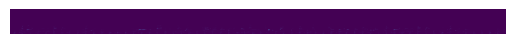

Mel spec from gztan (torchaudio.dataset)
Image:  <class 'numpy.ndarray'> of shape (128, 862) and dtype float32
Image:  max: 402.538544  min: 0.000000  mean: 1.172411  std: 7.227195


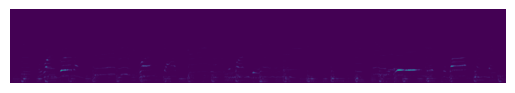

ValueError: operands could not be broadcast together with shapes (128,2586) (128,862) 

In [106]:
# Load a spectrogram from the dataset on disk

spec_path = os.path.join(datapath, 'spectrograms/mel/1024_256_128/blues/blues.00000.pkl')

with open(spec_path, 'rb') as f:
    loaded_spec = pickle.load(f) # load this pickle file, expected a tensor

img = loaded_spec.squeeze(0).cpu().numpy()
#img = np.expand_dims(img, 2)
#print(img.shape, type(img), img.dtype)
#img_disk = np.concatenate((img,img,img), axis=2)
img_disk = img

# Load the same spectrogram from GZTAN to compare
img = waveforms[0]['mel'].cpu().numpy()
#img = np.expand_dims(img, 2)
#print(img.shape, type(img), img.dtype)
#img_gztan = np.concatenate((img,img,img), axis=2)
img_gztan = img

print("Mel spec from disk")
stat_img(img_disk, origin='lower')

print("Mel spec from gztan (torchaudio.dataset)")
stat_img(img_gztan, origin='lower')

print("Difference MSE: ", ((img_disk - img_gztan)**2).mean())

# Scale for dreaming
img_gztan = img_gztan[:, :800] # cut the audio to a small snippet
img_gztan_logscale, mini, maxi = minmax_scale_log(img_gztan)
print(f'mean: {img_gztan_logscale.mean()} min: {img_gztan_logscale.min()} max: {img_gztan_logscale.max()} premin: {mini} premax: {maxi}')

In [11]:
# Reconstruction...

melspec = invert_minmax_scale_log(img_gztan_logscale, mini, maxi) # convert back to original scale
melspec = torch.from_numpy(melspec)
print("Melspec: ", melspec.shape, melspec.dtype, type(melspec))

stft = mel2stft(melspec) # this can take a while to converge...
print("Resulting STFT Audio:", stft.shape)

wav = stft2wav(stft)

Melspec:  torch.Size([128, 800]) torch.float32 <class 'torch.Tensor'>
Building STFT from Mel Spectrogram (tolerance:1.0) ... This can take a while!
Done!
Resulting STFT Audio: torch.Size([513, 800])
Input image shape torch.Size([513, 800])


## 2. Random Noise

Image:  <class 'numpy.ndarray'> of shape (128, 800, 1) and dtype float64
Image:  max: 0.200000  min: 0.000002  mean: 0.100311  std: 0.057717


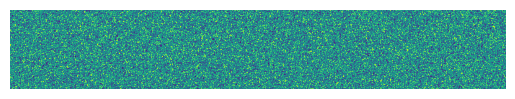

In [113]:
# Dream on noise
noise = np.random.rand(128, 800, 1) / 5.0
stat_img(noise)

## 3. Time-Frequency Patterns

Image:  <class 'numpy.ndarray'> of shape (128, 862) and dtype float64
Image:  max: 0.999998  min: 0.000000  mean: 0.003907  std: 0.054015


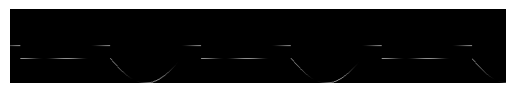





Horizontal Lines, Octave Relationship
Image:  <class 'numpy.ndarray'> of shape (128, 862) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.117188  std: 0.321644


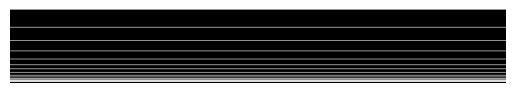





Full Spectrum wave along Time Axis
Image:  <class 'numpy.ndarray'> of shape (128, 862) and dtype float64
Image:  max: 0.999997  min: 0.000005  mean: 0.504453  std: 0.355409


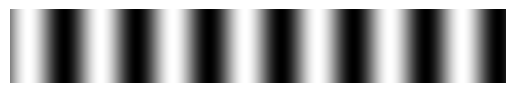

Image:  <class 'numpy.ndarray'> of shape (128, 862) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.037123  std: 0.189063


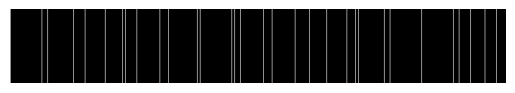

Building STFT from Mel Spectrogram (tolerance:1.0) ... This can take a while!
Done!
Resulting STFT Audio: torch.Size([513, 862])
Input image shape torch.Size([513, 862])


In [58]:
target_dim = (128, 862) # Mel spectrum

# Sinusoidal Pattern
sinus_img = np.zeros(target_dim)
for i in np.arange(0, target_dim[1]):
    idx = int( target_dim[0] * ((np.sin(i * 0.02) + 1)/2))
    val = (np.sin(i * 0.08) + 1)/2
    if idx <= target_dim[0] / 3:
        sinus_img[idx, i] = val
    elif idx < target_dim[0] / 3 * 2:
        sinus_img[int(target_dim[0] / 2), i] = val
    elif idx >= target_dim[0] / 3 * 2:
        sinus_img[int(target_dim[0] / 3), i] = val

stat_img(sinus_img, origin='lower', gray=True)


# Octaves
tone_img = np.zeros(target_dim)
tone_steps = np.geomspace(2, target_dim[0]-1, num=16).astype('int')
for i in np.arange(0, target_dim[1]):
    for j in tone_steps:
        tone_img[j, i] = 1.0
print("\n\n\n\nHorizontal Lines, Octave Relationship")
stat_img(tone_img, origin='lower', gray=True)

# Wave
print("\n\n\n\nFull Spectrum wave along Time Axis")
wave_img = np.zeros(target_dim)
for i in np.arange(0, wave_img.shape[1]):
    val = (np.sin(i * 0.05) + 1)/2
    wave_img[:, i] = val
stat_img(wave_img, origin='lower', gray=True)

# Click / Tone
click_img = np.zeros(target_dim)
clicks1 = np.arange(0, target_dim[1], 200)
clicks2 = np.arange(0, target_dim[1], 65) 
clicks3 = np.arange(0, target_dim[1], 55) 
click_img[:, clicks1] = 1.0
click_img[:, clicks2] = 1.0
click_img[:, clicks3] = 1.0
#for i in np.arange(0, click_img.shape[1]):
stat_img(click_img, origin='lower', gray=True)

stft = mel2stft(tone_img) # this can take a while to converge...
print("Resulting STFT Audio:", stft.shape)
wav = stft2wav(stft)

# Horizontal line fragments

# Stacked Horizontal line fragments

# Dreaming function (without octaves)

In [93]:
# @title Dreaming function

# Expects image to be a numpy array with dimensions HxWx3
def dream(image, model, iterations, dream_stepsize, unit=0, report_interval=5, sched_stepsize=None, gamma=0.8):
    """ Updates the image to maximize output unit for n iterations """
    
    print(f"Dream of {unit} {class2label[unit]} ... {image.shape}")

    image = preprocess(image)
    
    # Convert the numpy array image into a requires_grad=True Tensor that we will optimize
    image = torch.tensor(image, requires_grad=True, dtype=torch.float, device=DEVICE)


    if sched_stepsize is None:
        sched_stepsize = report_interval
    
    best_dream = image.detach().cpu().data.numpy()
    best_activation = 0
    
    # Optimization loop
    for i in range(iterations):
        # Learning without optimizer
        model.zero_grad()
        out = model(image.unsqueeze(0))
        activation = out[0][unit]
        activation.backward()
                
        with torch.no_grad():
            # TODO: try normalizing gradients
            # See: https://www.tensorflow.org/tutorials/generative/deepdream
            
            # May want to use this instead
            #absgrad = torch.abs(image.grad)
            #norm_step = dream_stepsize / absgrad.mean()
            #image += norm_step * image.grad
            
            # Alternative to the above which uses negative gradients to inhibit some pixels
            image += dream_stepsize * image.grad
            
            image = clip(image) # TODO: try scaling instead of clipping        

        if activation.data > best_activation:
            best_activation = activation.detach().cpu().data
            best_dream = image.detach().cpu().data.numpy()
        
        if i % report_interval == 0:
            print(f"{i}: activation {activation.shape}: {activation.data:.3f}   stepsize: {dream_stepsize:.6f}")                        
            stat_img(deprocess(best_dream), origin='lower')
       
        # Step the learning rate
        if (i+1) % sched_stepsize == 0:
            dream_stepsize = dream_stepsize * gamma
        
        image.grad.zero_()
        
        del out
        del activation
    
    print(f"Done dreaming of {class2label[unit]} ... best activation {best_activation}")
    
    return deprocess(best_dream)

### Dreaming hyperparameters and input image

In [108]:
# Load image to be dreamed:
#image = sinus_img
#image = wave_img
#image = click_img
#image = tone_img
#image = noise
#image = waveformsbyclass['blues']['mel']
image = waveformsbyclass['rock']['mel']

# Copy across RGB channels
image = np.expand_dims(image, 2)
image = np.concatenate((image, image, image), axis=2)

# Model to use
trained_model = vgg16

# Hyper parameters for deep dreaming
#dreaming_unit = label2class['disco'] # depends on genre of interest
dreaming_unit = label2class['reggae'] # depends on genre of interest
learning_rate = 1e-02
iterations = 50 # number of times the deep dream loop should be run

learning_rate = 5e-02
iterations = 3000

learning_rate = 1e-01
iterations = 400
scheduler_stepsize=50
scheduler_gamma=0.5

learning_rate = 200
iterations = 400
scheduler_stepsize=25
scheduler_gamma=0.5


### Run the dreaming function

Dream of 8 reggae ... (128, 862, 3)
0: activation torch.Size([]): 99.411   stepsize: 200.000000
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.371858  std: 0.386471


<ipython-input-93-e50e8dd4b8d1>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True, dtype=torch.float, device=DEVICE)


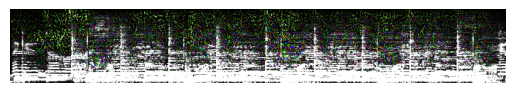

20: activation torch.Size([]): 323.531   stepsize: 200.000000
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.399741  std: 0.397356


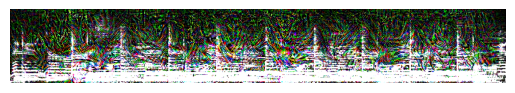

40: activation torch.Size([]): 487.408   stepsize: 100.000000
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.407940  std: 0.401427


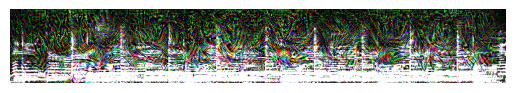

60: activation torch.Size([]): 693.582   stepsize: 50.000000
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.421823  std: 0.409628


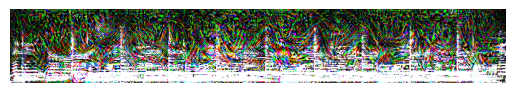

80: activation torch.Size([]): 651.134   stepsize: 25.000000
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.424788  std: 0.411387


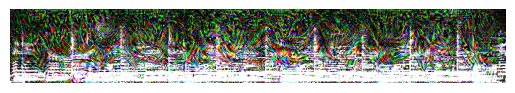

100: activation torch.Size([]): 728.216   stepsize: 12.500000
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.427952  std: 0.413268


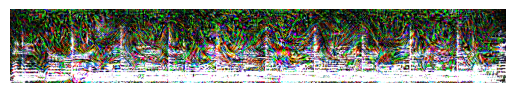

120: activation torch.Size([]): 686.447   stepsize: 12.500000
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.427952  std: 0.413268


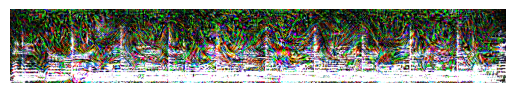

140: activation torch.Size([]): 672.435   stepsize: 6.250000
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.427952  std: 0.413268


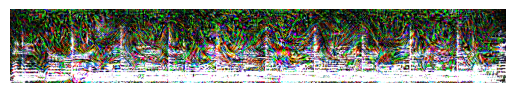

160: activation torch.Size([]): 577.827   stepsize: 3.125000
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.427952  std: 0.413268


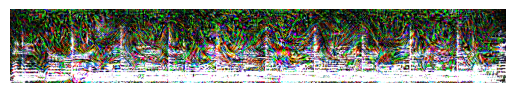

180: activation torch.Size([]): 701.905   stepsize: 1.562500
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.431064  std: 0.415276


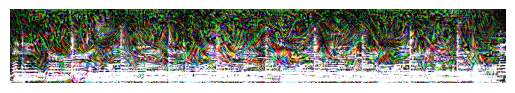

200: activation torch.Size([]): 681.700   stepsize: 0.781250
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.431064  std: 0.415276


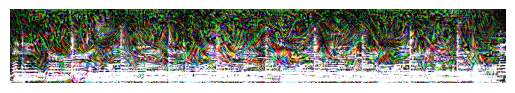

220: activation torch.Size([]): 741.271   stepsize: 0.781250
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.431064  std: 0.415276


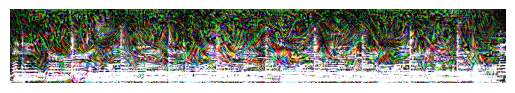

240: activation torch.Size([]): 759.022   stepsize: 0.390625
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.431341  std: 0.415452


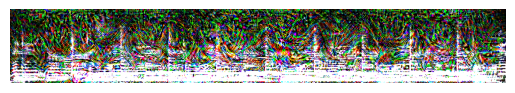

260: activation torch.Size([]): 878.570   stepsize: 0.195312
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.431385  std: 0.415480


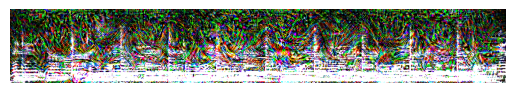

280: activation torch.Size([]): 732.752   stepsize: 0.097656
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.431385  std: 0.415480


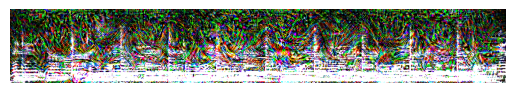

300: activation torch.Size([]): 574.145   stepsize: 0.048828
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.431385  std: 0.415480


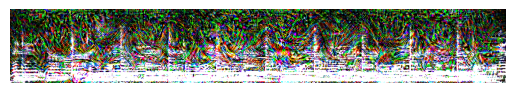

320: activation torch.Size([]): 594.447   stepsize: 0.048828
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.431385  std: 0.415480


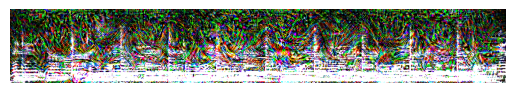

340: activation torch.Size([]): 793.068   stepsize: 0.024414
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.431385  std: 0.415480


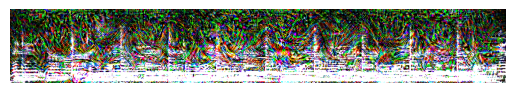

360: activation torch.Size([]): 595.558   stepsize: 0.012207
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.431385  std: 0.415480


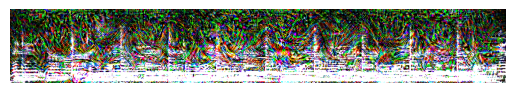

380: activation torch.Size([]): 690.190   stepsize: 0.006104
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)
Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.431385  std: 0.415480


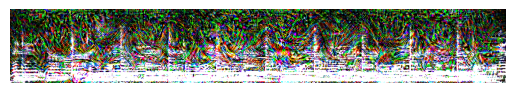

Done dreaming of reggae ... best activation 925.6023559570312
Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 128, 862)


In [109]:
ri = int(iterations / 20)
original_image = image
dreamed_image = dream(
    image=image, 
    model=trained_model, 
    iterations=iterations, 
    dream_stepsize=learning_rate, 
    unit=dreaming_unit, 
    report_interval=ri,
    sched_stepsize=scheduler_stepsize,
    gamma=scheduler_gamma
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float32
Image:  max: 604.835388  min: 0.000000  mean: 2.968291  std: 12.554217


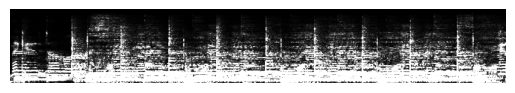

Image:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.431385  std: 0.415480


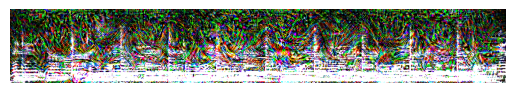

Difference MSE logscale:  161.03363436971054


In [110]:
stat_img(original_image, origin='lower')
stat_img(dreamed_image, origin='lower')
print("Difference MSE logscale: ", ((dreamed_image - original_image)**2).mean())

In [85]:
# Optional, invert log scale
#invert_log_scale = True
invert_log_scale = False

Building STFT from Mel Spectrogram (tolerance:1.0) ... This can take a while!
Done!
Building STFT from Mel Spectrogram (tolerance:1.0) ... This can take a while!
Done!
Building STFT from Mel Spectrogram (tolerance:1.0) ... This can take a while!
Done!
Resulting STFT Audio: torch.Size([513, 862])
Red
Image:  <class 'torch.Tensor'> of shape torch.Size([128, 862]) and dtype torch.float32
Image:  max: 1.000000  min: 0.000000  mean: 0.435928  std: 0.412774


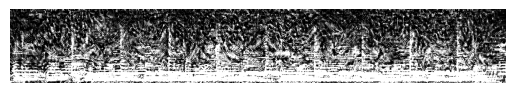

Input image shape torch.Size([513, 862])


Green
Image:  <class 'torch.Tensor'> of shape torch.Size([128, 862]) and dtype torch.float32
Image:  max: 1.000000  min: 0.000000  mean: 0.454515  std: 0.422246


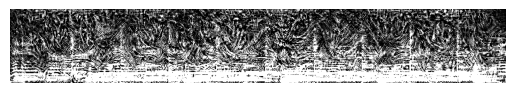

Input image shape torch.Size([513, 862])


Blue
Image:  <class 'torch.Tensor'> of shape torch.Size([128, 862]) and dtype torch.float32
Image:  max: 1.000000  min: 0.000000  mean: 0.403712  std: 0.409731


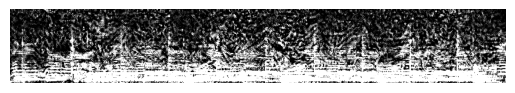

Input image shape torch.Size([513, 862])


In [111]:
melspec = torch.from_numpy(dreamed_image.astype('float32'))
melR = melspec[:,:,0]
melG = melspec[:,:,1]
melB = melspec[:,:,2]

if invert_log_scale:
    melR = invert_minmax_scale_log(melR, mini, maxi)
    melG = invert_minmax_scale_log(melR, mini, maxi)
    melB = invert_minmax_scale_log(melR, mini, maxi)

stftR = mel2stft(melR) # this can take a while to converge...
stftG = mel2stft(melG) # this can take a while to converge...
stftB = mel2stft(melB) # this can take a while to converge...
print("Resulting STFT Audio:", stftR.shape)
print("Red")
stat_img(melR, origin='lower', gray=True)
wavR = stft2wav(stftR)
print("Green")
stat_img(melG, origin='lower', gray=True)
wavG = stft2wav(stftG)
print("Blue")
stat_img(melB, origin='lower', gray=True)
wavB = stft2wav(stftB)


In [40]:
melspec = invert_minmax_scale_log(dreamed_image.astype('float32'), mini, maxi) # convert back to original scale
print("Difference MSE: ", ((melspec - img_gztan[:,:800,:])**2).mean())
melspec = torch.from_numpy(melspec[:,:,0]) # Get just one channel
print("Melspec: ", melspec.shape, melspec.dtype)
stft = mel2stft(melspec) # this can take a while to converge...
print("Resulting STFT Audio:", stft.shape)
wav = stft2wav(stft)

Difference MSE:  59.400803
Melspec:  torch.Size([128, 800]) torch.float32
Resulting STFT Audio: torch.Size([513, 800])
Input image shape torch.Size([513, 800])
